In [1]:
import ast
import random
import pickle
import json
from collections import OrderedDict
import warnings
import threading
from multiprocessing.pool import ThreadPool
import concurrent.futures

import pandas as pd
import numpy as np
import seaborn as sns
from numpy.linalg.linalg import LinAlgError
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
from matplotlib_venn import venn2, venn3, venn3_circles
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFdr
from scipy.stats import chi2
from patsy import ModelDesc, dmatrix

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'
# sns.set_style('white')

In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

In [398]:
df = (data
      .loc[:, data_cols]
      .T
      .join(fg[['animal', 'week', 'bg', 'bg_type', 'ogtt', 'insulin']]))
df['animal'] = df['animal'].astype('category')
df['week_cat'] = df['week'].astype('category')
# df = df.loc[df['bg_type'] == 'FBG']
# df

In [418]:
# feature = data.loc[data['molec_class'] == 'TG'].index[86]
feature = data.index[1200]
print(feature, data.loc[feature, 'ID'])
ttest = smf.mixedlm(f'{feature} ~ bg_type', data=df,
                    groups='animal').fit(reml=True)
ttest.summary()

l_705 TG 56:7


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM  Dependent Variable:  l_705   
No. Observations:  59       Method:              REML    
No. Groups:        10       Scale:               0.5235  
Min. group size:   5        Log-Likelihood:      -75.8365
Max. group size:   6        Converged:           Yes     
Mean group size:   5.9                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      25.782    0.303 85.186 0.000 25.189 26.375
bg_type[T.RBG] -0.359    0.189 -1.903 0.057 -0.729  0.011
animal Var      0.734    0.587                           
=========================================================

"""

l_641 TG 16:1_18:3_18:2


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:             MixedLM  Dependent Variable:  l_641   
No. Observations:  59       Method:              ML      
No. Groups:        10       Scale:               0.3794  
Min. group size:   5        Log-Likelihood:      -64.3822
Max. group size:   6        Converged:           Yes     
Mean group size:   5.9                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      22.151    0.230 96.495 0.000 21.702 22.601
bg_type[T.RBG] -0.239    0.253 -0.946 0.344 -0.736  0.257
bg              0.005    0.001  3.673 0.000  0.002  0.007
animal Var      0.346    0.331                           
=========================================================

"""

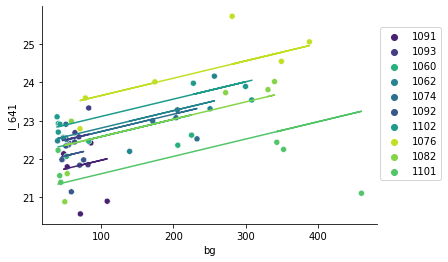

In [365]:
feature = data.loc[data['molec_class'] == 'TG'].index[15]
print(feature, data.loc[feature, 'ID'])
model = smf.mixedlm(f'{feature} ~ bg + bg_type', data=df,
                    groups='animal').fit(reml=False)
display(model.summary())
sns.scatterplot(
    data=df, x='bg', y=feature, hue=df['animal'].astype('str'), palette=colors,
)


for animal in model.random_effects:
    x = df.loc[(df['animal'] == animal), 'bg']
    random_intercept = model.random_effects[animal][0]
    intercept = model.fe_params['Intercept']
    try: 
        week_coef = model.fe_params['week']
        weeks = df.loc[df['animal'] == animal, 'week']
    except: week_coef = 0
    try: bg_type_coef = model.fe_params['bg_type']
    except: bg_type_coef = 0
    bg_coef = model.fe_params['bg']
    y = intercept + random_intercept + bg_type_coef + (bg_coef * x)
    plt.plot(x, y,
             color=colors[str(animal)]
            )
plt.legend(loc=(1.01, 0.2))
sns.despine()

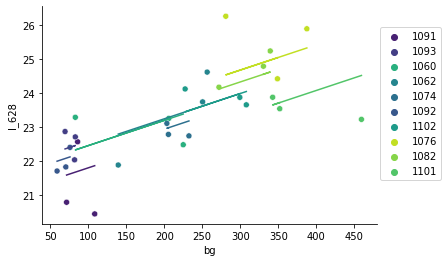

In [253]:
sns.scatterplot(
    data=df, x='bg', y=feature, hue=df['animal'].astype('str'), palette=colors,
)
for animal in model.random_effects:
    x = df.loc[(df['animal'] == animal), 'bg']
    random_intercept = model.random_effects[animal][0]
    intercept = model.fe_params['Intercept']
    bg_coef = model.fe_params['bg']
    y = intercept + random_intercept + (bg_coef * x)
    plt.plot(x, y,5
             color=colors[str(animal)]
            )
plt.legend(loc=(1.01, 0.2))
sns.despine()

,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,...,l_914,l_915,l_916,animal,week,bg,bg_type,ogtt,insulin,week_cat
1091_8_FBG,18.724636,20.779580,24.180859,24.887680,27.518513,23.065294,22.586018,21.670779,22.690034,22.292465,...,19.073429,19.091184,18.620317,1091,8,53.333333,FBG,19060.0,653.495,8
1091_10_FBG,17.600816,20.575689,23.583080,24.713250,27.163433,23.132749,22.706016,22.116365,22.690580,21.771079,...,20.133479,19.996615,19.778245,1091,10,48.500000,FBG,19060.0,653.495,10
1093_8_FBG,16.451618,20.902141,23.548337,24.647222,27.405718,23.138487,22.633815,22.139245,22.665739,22.337209,...,21.315704,21.404572,21.063577,1093,8,47.000000,FBG,25057.5,453.485,8
1093_9_FBG,18.286166,20.877460,22.368788,24.526725,27.051667,23.178672,22.559027,22.469655,22.629048,22.274394,...,21.529536,21.430516,20.968101,1093,9,64.000000,FBG,25057.5,453.485,9
1093_10_FBG,18.054307,20.415204,22.704412,24.404735,26.756463,23.060708,22.793575,22.273762,22.923587,21.875123,...,20.116586,20.214040,19.638826,1093,10,56.500000,FBG,25057.5,453.485,10
1060_8_FBG,17.594730,20.198771,23.895235,24.714910,17.148994,22.653452,22.084504,21.397206,22.065355,21.679060,...,20.517490,20.603688,19.836798,1060,8,41.000000,FBG,48742.5,422.940,8
1060_9_FBG,21.809716,20.524661,24.263211,24.520405,19.169210,23.207043,22.450039,21.424020,22.534742,21.849560,...,20.671826,20.788152,20.234283,1060,9,48.000000,FBG,48742.5,422.940,9
1060_10_FBG,18.748109,20.303969,23.084387,24.792384,27.209158,22.793616,22.563256,21.784634,22.664376,21.631447,...,19.568571,19.769735,19.279616,1060,10,52.500000,FBG,48742.5,422.940,10
1062_8_FBG,18.098242,21.019048,24.873347,24.787384,21.774699,23.221875,22.352220,21.964129,22.346725,22.098343,...,19.348489,19.240306,18.585339,1062,8,52.333333,FBG,43717.5,432.020,8
1062_9_FBG,17.286972,20.641492,24.131393,24.408454,23.189693,22.831914,22.452734,21.841118,22.588667,21.916517,...,19.373546,19.419154,18.670027,1062,9,48.000000,FBG,43717.5,432.020,9


l_569 TG 20:5_22:6_22:6


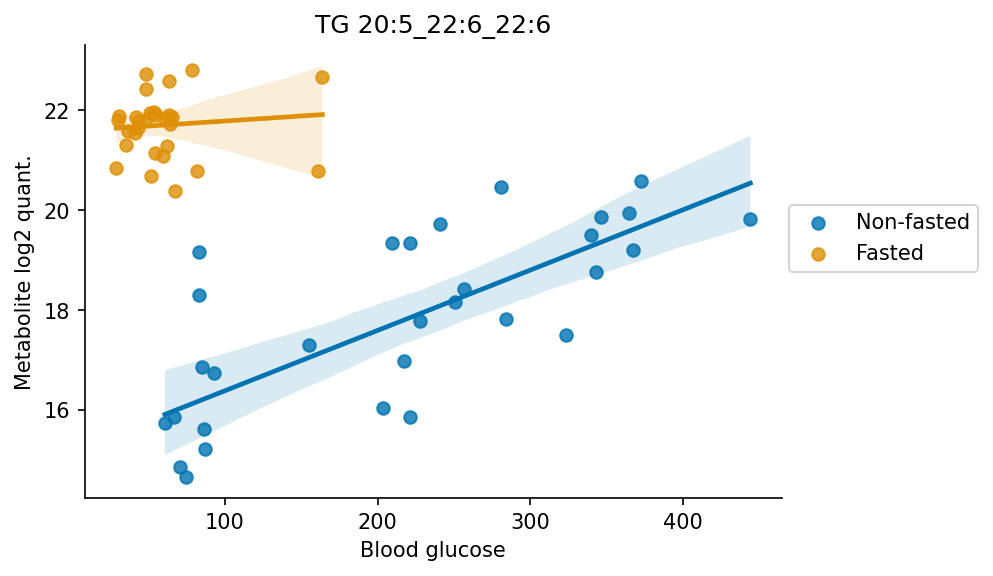

In [552]:
bgdf = df.loc[~((df['bg_type'] == 'FBG') & (df['bg'] > 120))]

# feature = data.loc[data['molec_class'] != 'Unidentified'].index[442]  
feature = data.loc[data['molec_class'] == 'TG'].index[0]  # 72 0 
print(feature, data.loc[feature, 'ID'])
for bg_type in ['RBG', 'FBG']:
    rp = sns.regplot(
        data=df.loc[df['bg_type'] == bg_type], x='bg', y=feature, color=colors[bg_type], robust=True, n_boot=150,
        x_partial='week',
        label=('Non-fasted' if bg_type == 'RBG' else 'Fasted')
    )
rp.set(
    title=data.loc[feature, 'ID'],
    ylabel='Metabolite log2 quant.',
    xlabel='Blood glucose',
)
fig = plt.gcf()
fig.set_dpi(150)
fig.set_facecolor('white')
plt.legend(loc=(1.01, 0.5))
sns.despine()

<AxesSubplot:xlabel='bg', ylabel='l_569'>

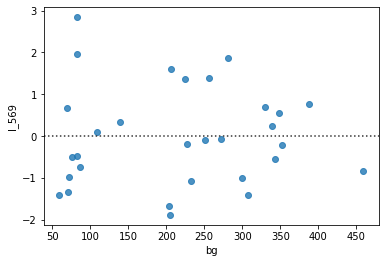

In [481]:
sns.residplot(
    data=df.loc[df['bg_type'] == 'RBG'], x='bg', y=feature,
#     x_partial='week'
)